## Demonstration of time series forecasting using Holt-Winters and time series linear models (tslm)
...maybe some ggplot stuff too.

In [1]:
# imports
library(tidyquant)
library(timekit)
library(ggplot2)
library(forecast)

Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: PerformanceAnalytics
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Loading required package: quantmod
Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: tidyverse
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
as.difftime(): lubridate, base
date():        lubridate, base
filter():      dplyr, stats
first():       dplyr, xts
intersect():   lubridate, 

In [2]:
# read in that sweet, sweet data
data <- read.table(
  './household_power_consumption.txt',
    sep=";",
  header=TRUE,
  as.is=TRUE)

# Preprocessing

In [3]:
#remove NAs
data <- na.omit(data)

# create dateTime column
data <- cbind(
  data,paste(data$Date,data$Time), 
  stringsAsFactors=FALSE)
colnames(data)[10] <-"dateTime"

# move dateTime col to col1 of table
data <- data[,c(ncol(data), 1:(ncol(data)-1))]

# remove the old date and time cols
data <- data[,-c(2:3)]

# convert dateTime to POSIXlt
data$dateTime <- as.POSIXct(strptime(
  data[,1],
  format="%d/%m/%Y %H:%M:%S",
  tz=""
))

# convert data types
data$Global_active_power <- as.double(data$Global_active_power)
data$Global_reactive_power <- as.double(data$Global_reactive_power)
data$Voltage <- as.double(data$Voltage)
data$Global_intensity <- as.double(data$Global_intensity)
data$Sub_metering_1 <- as.integer(data$Sub_metering_1)
data$Sub_metering_2 <- as.integer(data$Sub_metering_2)
data$Sub_metering_3 <- as.integer(data$Sub_metering_3)

# Grouping and aggregation of data
Note that the last few weeks of 2006 have been chopped off to allow the time series function to start its index at week 1 rather than week 50. Perhaps there is a workaround for this...

In [4]:
# create detail metric data, group by year/week
dataTsYW <- 
  cbind(tk_get_timeseries_signature(data[,1]),data) %>%
  group_by(year, week) %>%
  summarise(SM1 = sum(Sub_metering_1)/1000,
            SM2 = sum(Sub_metering_2)/1000,
            SM3 = sum(Sub_metering_3)/1000) %>% 
  arrange(year, week)

# cull out the last 4 weeks of 2006 and throw out 53rd weeks
# this makes a nice (2007, 1) index for the ts() object
dataTsYW <- subset(dataTsYW, ((year > 2006)&(week != 53)))

# Charting and plotting
Here we've used six methods. The first method is for all three submeter time series objects, and methods 2 through 6 contain only data from the first submeter.

1. ts.plot() with all three submeters (SM1, SM2, and SM3)
2. plot() with the Holt-Winters smoothing function
3. plot.forecast() from the forecast package, with a Holt-Winters smoothed input timeseries
4. plot() with a 1 year look-ahead forecasted time series linear model
5. plot() with the seasonal decomposition chart from the stats package, and
6. ggseasonplot(), which is in the forecast library and allows seasonal overlays

1.) ts.plot() with all three submeters (SM1, SM2, and SM3)

Note that all three time series are overlaid on the same chart.

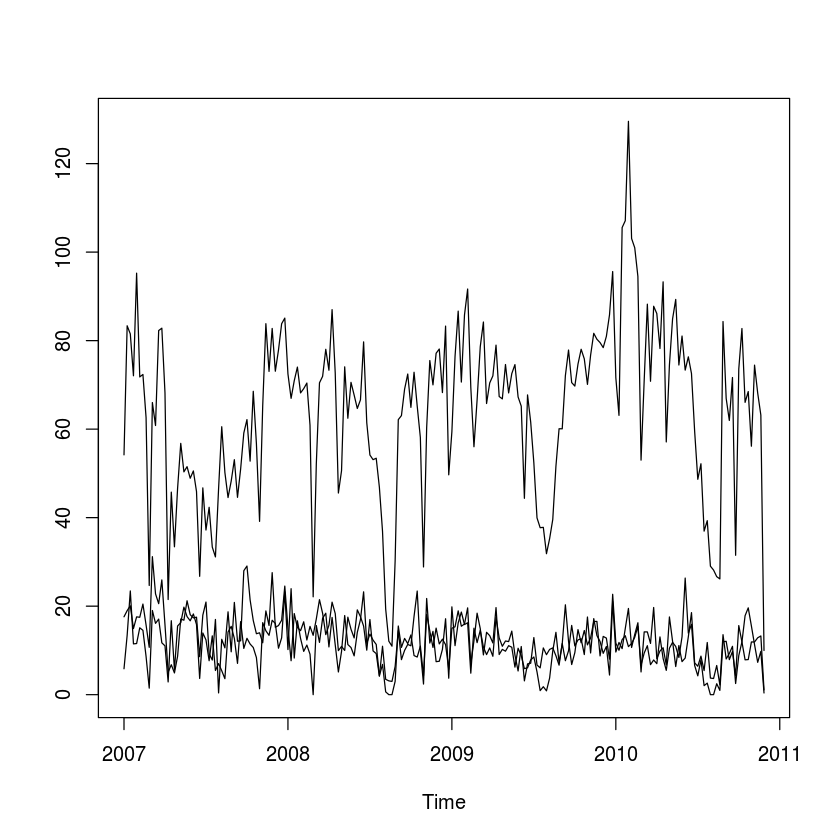

In [5]:
# plot SM1,2,3 with no Holt-Winters smoothing
ts.plot(
  ts(dataTsYW[,3], start=(c(2007, 1)), frequency=52),
  ts(dataTsYW[,4], start=(c(2007, 1)), frequency=52),
  ts(dataTsYW[,5], start=(c(2007, 1)), frequency=52)
)

2.) plot() with the Holt-Winters smoothing function

Note that Holt Winters is just a smoothing function. It doesn't have anything to do with Winter.

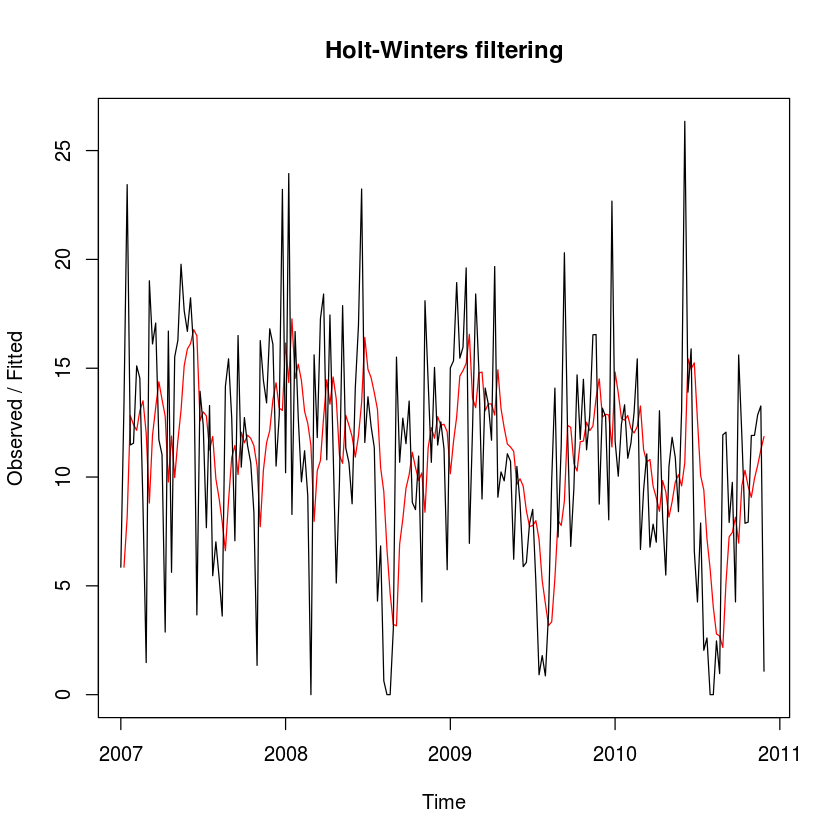

In [6]:
# plot SM1 with HW smoothing (can only do one submeter at a time)
plot(
  HoltWinters(
    ts(dataTsYW[,3], start=(c(2007, 1)), frequency=52), 
    beta=FALSE, gamma=FALSE
  )
)

3.) plot.forecast() from the forecast package, with a Holt-Winters smoothed input timeseries

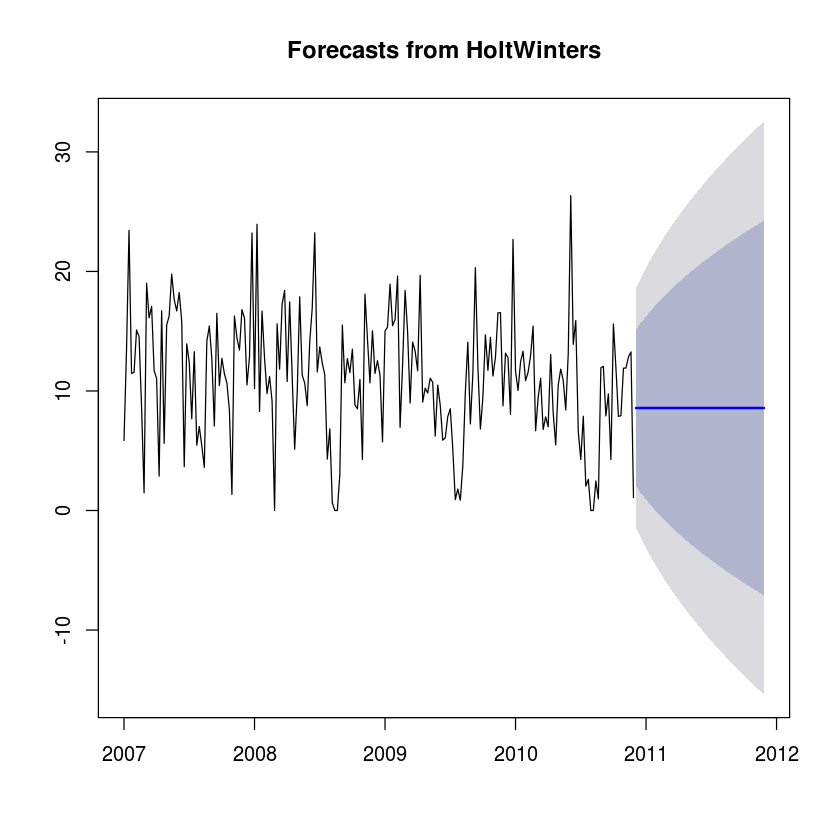

In [7]:
# plot SM1 HW forecast for 1 year (52 weeks)
forecast::plot.forecast(
  forecast::forecast.HoltWinters(
    HoltWinters(
      ts(dataTsYW[,3], start=(c(2007, 1)), frequency=52), 
      beta=FALSE, gamma=FALSE
    ), 
    h=52
  )
)

4.) plot() with a 1 year look-ahead forecasted time series linear model

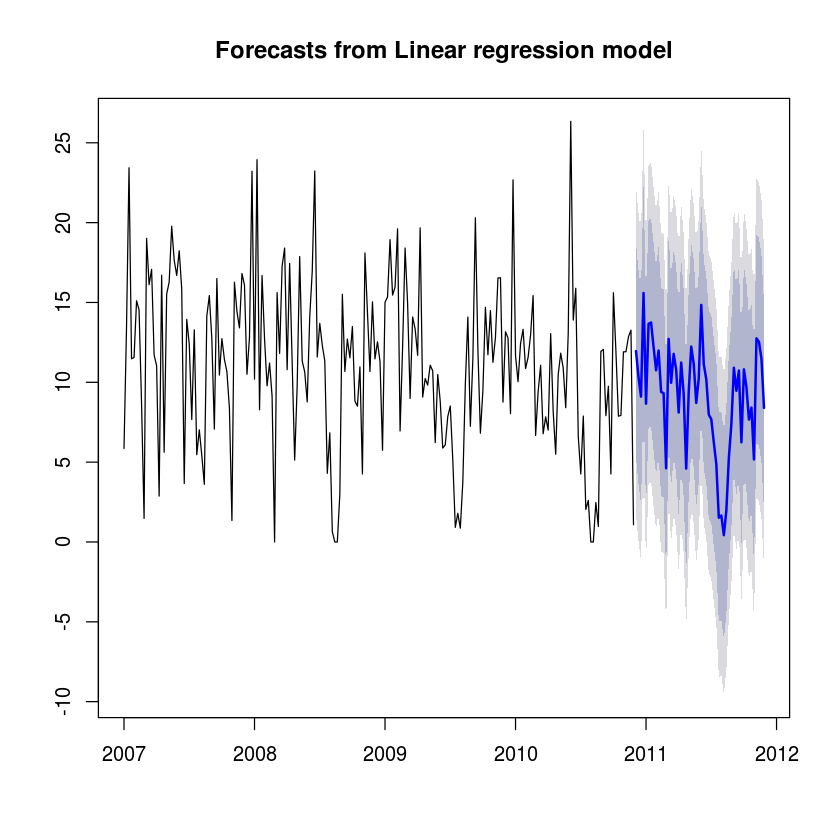

In [8]:
# create a time series linear model 52 week forecast
plot(
  forecast(
    tslm(
      ts(dataTsYW[,3], start=(c(2007, 1)), frequency=52) 
      ~ trend + season
    ),
    h=52
  )
)

5.) plot() with the seasonal decomposition chart from the stats package, and

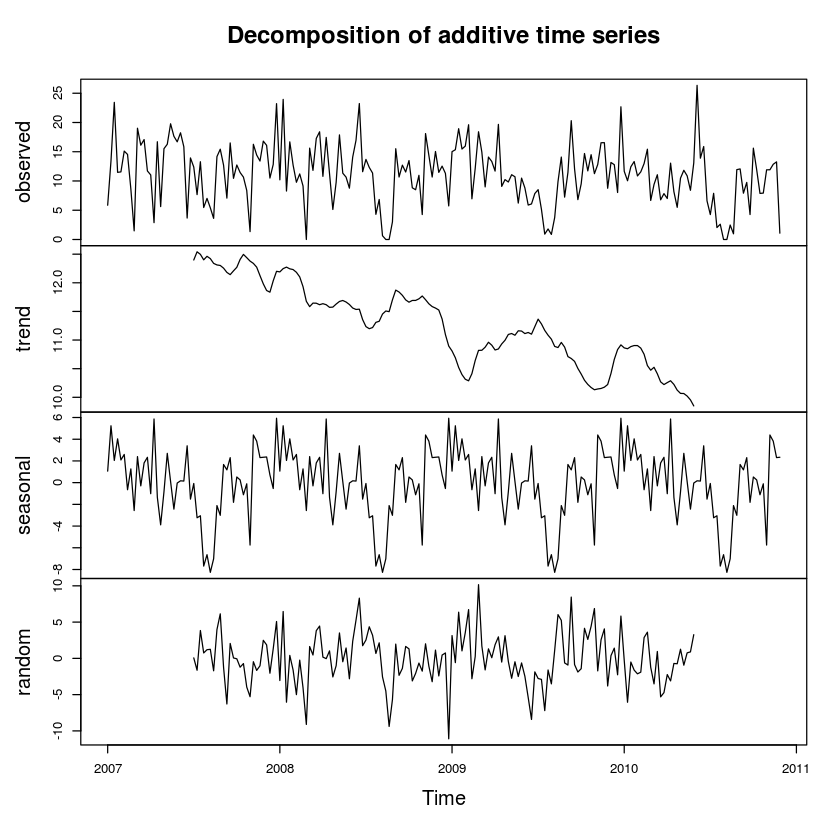

In [9]:
# show time series seasonal decomposition for SM1
plot(
  decompose(
    ts(dataTsYW[,3], start=(c(2007, 1)), frequency=52)
  )
)

6.) ggseasonplot(), which is in the forecast library and allows seasonal overlays

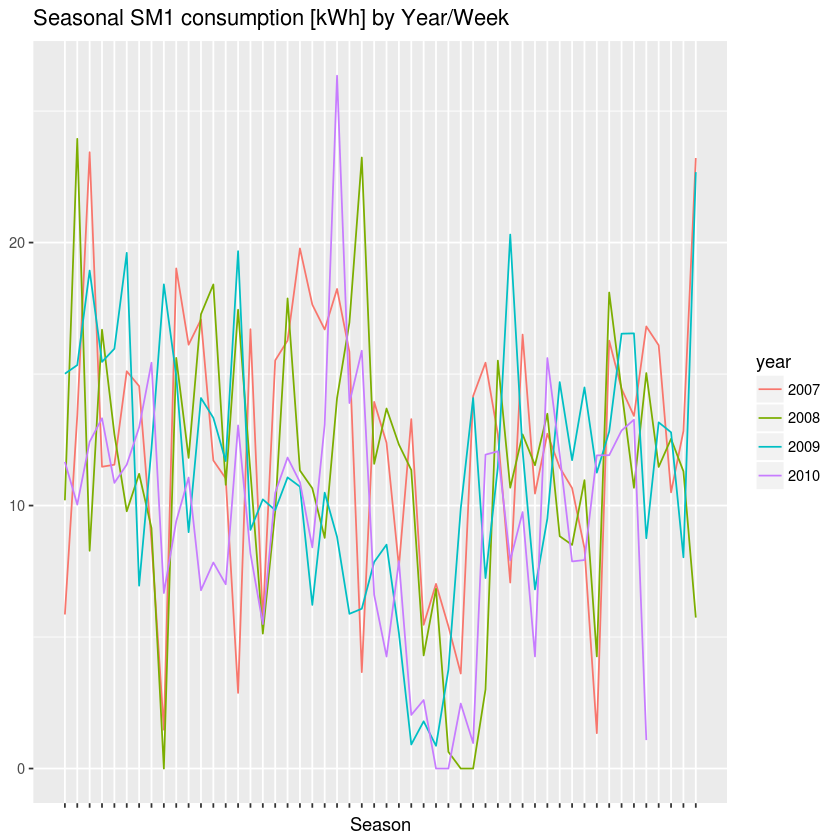

In [11]:
# seasonal ggplot
forecast::ggseasonplot(
  ts(dataTsYW[,3], start=(c(2007, 1)), frequency=52) 
) + labs(title="Seasonal SM1 consumption [kWh] by Year/Week")